Aggregation, Filtering and Dispersion Tests
==

This notebook runs a variety of tracer tests to compare and refine
aggregated, non-tidal DWAQ models.

The runs are in 3D, but the results are just plotted for the surface layer.


In [1]:
# Quiet some of the logging
# workaround via specifying an invalid value first
%config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
%config Application.log_level='WARN'
import logging
logging.getLogger().setLevel(logging.WARN)
log = logging.getLogger()
log.debug('Test debug')
log.info('Test info')
log.warning('Test warn')

ERROR:root:The 'log_level' trait of an IPKernelApp instance must be any of (0, 10, 20, 30, 40, 50, 'DEBUG', 'INFO', 'WARN', 'ERROR', 'CRITICAL'), but a value of 'WORKAROUND' <class 'str'> was specified.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
from shapely import geometry, wkt
import stompy.plot.cmap as scmap
import xarray as xr
from stompy.grid import unstructured_grid
import numpy as np
import stompy.model.delft.waq_scenario as dwaq
import logging as log
from stompy import utils
from stompy.plot import plot_wkb
import os
import six
from matplotlib import gridspec
%matplotlib inline

In [3]:
cmap=scmap.load_gradient('turbo.cpt') # a less offensive 'jet'

In [4]:
# configure DWAQ:
DELFT_SRC="/home/alliek/software/Delft3D-FM/64634"
DELFT_SHARE=os.path.join(DELFT_SRC,"share","delft3d")
DELFT_LIB=os.path.join(DELFT_SRC,"lib")

os.environ['DELFT_SRC']=DELFT_SRC
os.environ['DELFT_SHARE']=DELFT_SHARE
# not great - really should check what's already in there.
os.environ['LD_LIBRARY_PATH']=DELFT_LIB

In [5]:
hydro_agg6k=dwaq.HydroFiles("/hpcvol1/zhenlin/sfbay/ModelAggregation/dwaq-agg-arc6000_temp/com-wy2013c-agg.hyd")
hydro_agg6k.name='agg6k'

hydro_agg6k_lp=dwaq.HydroFiles("../../agg6k-lp/com-wy2013c-agg6k-lp.hyd")
hydro_agg6k_lp.name='agg6k_lp'

hydro_orig=dwaq.HydroFiles("/hpcvol1/public/sfb_dfm_v2/wy2013c/DFM_DELWAQ_wy2013c_adj/wy2013c.hyd")
hydro_orig.name='orig'

hydro_agg141=dwaq.HydroFiles("../../agg141/com-wy2013c-agg141.hyd")
hydro_agg141.name='agg141'

hydro_agg141_lp=dwaq.HydroFiles("../../agg141-lp/com-wy2013c-agg141-lp.hyd")
hydro_agg141_lp.name='agg141_lp'

In [6]:
class Blobber(object):
    """
    Wrap the gaussian blob process up into a self-contained class.
    """
    hydro=None
    base_path=None # must be set!

    force=False # whether to allow re-using an existing run
    
    # plume parameters
    X0=np.array([567500,4.16795e6])
    L=5000
    fig_num=None
    zoom=(552164., 595434., 4138443.,4186236.)
    txt_loc=[0.05,0.15] # axes coordinate for location of label
    
    # start time offset from start of hydro by this delta
    # give it some decent spinup time
    start_offset=np.timedelta64(75,'D')
    # set length of the run
    duration=np.timedelta64(5,'D')
    
    blob_name='gaussian' # used to form default base_path

    base_x_dispersion=0.0 # will be copied to the WaqModel
    integration_option="15.60" # if set, copied to WaqModel
    time_step=3000
    map_time_step=3000 # otherwise it will default to time_step, which could be really short.
    
    def __init__(self,**kw):
        utils.set_keywords(self,kw)   
        if self.base_path is None:
            self.base_path=self.calc_base_path()
                
            if self.start_offset!=np.timedelta64(75,'D'):
                # yuck.  dates.
                yyyymmdd=utils.to_datetime(utils.to_dt64(self.hydro.t_dn[0])+self.start_offset).strftime('%Y%m%d')
                self.base_path+="_%s"%(yyyymmdd)
    
            log.info("base_path defaults to %s"%self.base_path)
       
    def calc_base_path(self):
        details=""
        if self.base_x_dispersion!=0.0:
            details+="_Kx%g"%self.base_x_dispersion
        if self.integration_option!="15.60":
            details+="_int%s"%self.integration_option
        if self.duration!=np.timedelta64(5,'D'):
            ndays=int(self.duration/np.timedelta64(1,'D'))
            details+="_%ddays"%ndays


        return 'run_%s_%s%s'%(self.hydro.name,self.blob_name,details)
        
    def complete(self):
        """
        simulate and plot
        """
        self.run_waq_model()
        self.figure_3panels()
        return self # makes for more compact iteration loops later
        
    def release_conc_2d(self):
        grid=self.hydro.grid()
        X=grid.cells_centroid()
        
        c=np.exp( -((X-self.X0)**2).sum(axis=-1)/self.L**2 )
        c=c/c.max() # make max value 1
        return c
    
    def release_conc_3d(self):
        C_2d=self.release_conc_2d()
        C_3d=self.hydro.extrude_element_to_segment(C_2d)
        return C_3d

    def setup_model(self):
        # Create a WaqModel, add some tracers
        self.wm=wm=dwaq.WaqModel(hydro=self.hydro,
                                 overwrite=True,
                                 base_path=self.base_path,
                                 base_x_dispersion=self.base_x_dispersion,
                                 time_step=self.time_step)
        # add some option for balances.
        wm.integration_option="%s BALANCES-OLD-STYLE BAL_NOLUMPPROCESSES BAL_NOLUMPLOADS BAL_NOLUMPTRANSPORT"%self.integration_option
        wm.start_time+= self.start_offset
        wm.stop_time=wm.start_time + self.duration

        self.setup_tracers()
        
        wm.parameters['ACTIVE_VertDisp']=1
        wm.parameters['ScaleVDisp']=1.0 # probably needs to be smaller, but use this for now.
    
    def run_waq_model(self):
        assert self.base_path is not None,"Must specify base_path"
        
        if not self.force:
            if os.path.exists(os.path.join(self.base_path,'dwaq_map.nc')):
                log.info("Run seems to exist -- will not run again")
                self.wm=dwaq.WaqModel.load(self.base_path,load_hydro=False)
                return

        self.setup_model()
        
        wm=self.wm
        wm.cmd_write_hydro()
        wm.cmd_write_inp()
        wm.cmd_delwaq1()
        wm.cmd_delwaq2()
        wm.cmd_write_nc()

    def setup_tracers(self):
        # boundary condition will default to 0.0
        C_3d=self.release_conc_3d()
        self.wm.substances['dye1']=dwaq.Substance(initial=C_3d)
        self.setup_tracer_continuity()
        
    def setup_tracer_continuity(self):
        # continuity tracer:
        self.wm.substances['continuity']=dwaq.Substance(initial=1.0)
        # This adds a concentration=1.0 boundary condition on all the boundaries.
        all_bcs=[b.decode() for b in np.unique(self.hydro.boundary_defs()['type'])]
        self.wm.add_bc(all_bcs,'continuity',1.0)
        
    def figure_3panels(self):
        ds=xr.open_dataset(os.path.join(self.base_path,'dwaq_map.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

        fig,axs=plt.subplots(1,3,num=self.fig_num)
        self.fig=fig
        fig.set_size_inches([12,5],forward=True)

        scal='dye1'
        # initial
        ax=axs[0]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Initial",transform=ax.transAxes,va='top')
        coll_ic=grid_ds.plot_cells(values=ds[scal].isel(time=0,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])
        # at the end 
        ti=len(ds.time)-1
        ax=axs[1]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Final",transform=ax.transAxes,va='top')
        coll_ec=grid_ds.plot_cells(values=ds[scal].isel(time=-1,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])

        # continuity
        ax=axs[2]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Continuity",transform=ax.transAxes,va='top')
        coll_cont=grid_ds.plot_cells(values=ds['continuity'].isel(time=-1,layer=0),ax=ax,cmap='seismic',
                                     clim=[0.8,1.2])

        for coll in [coll_ic,coll_ec,coll_cont]:
            coll.set_lw(0.75)
            coll.set_edgecolor('face')
            
        for ax in axs:
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)

        fig_title=self.hydro.hyd_path
        if self.base_x_dispersion!=0.0:
            fig_title+= " Kx=%g"%self.base_x_dispersion
            
        fig.text(0.5,0.95,fig_title,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text

        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.
    

class BlobLSB(Blobber):
    """
    minor adjustment to put a blob in LSB
    """
    X0=np.array([582019,4.14719e6])
    L=5000
    blob_name='lsb_gaussian'
    #zoom=(552164., 595434., 4138443.,4186236.)

South Bay Blob
==

The choice of hydro is cryptically hidden in the filename at the top of each figure.

`lp` is lowpass, i.e. with tides removed.

`/hpcvol1/public/...` is the original full resolution hydrodynamics.


''

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


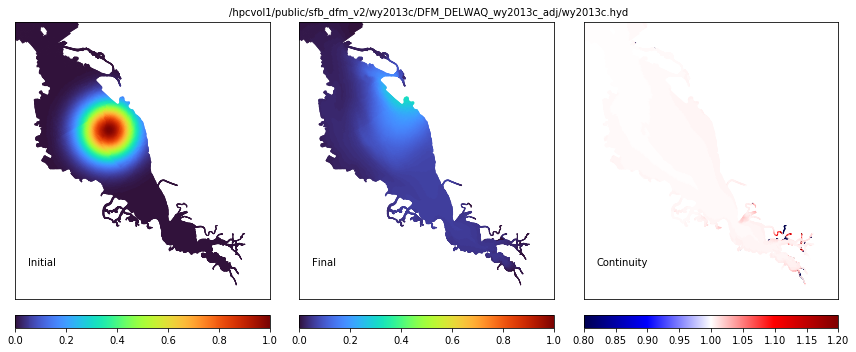

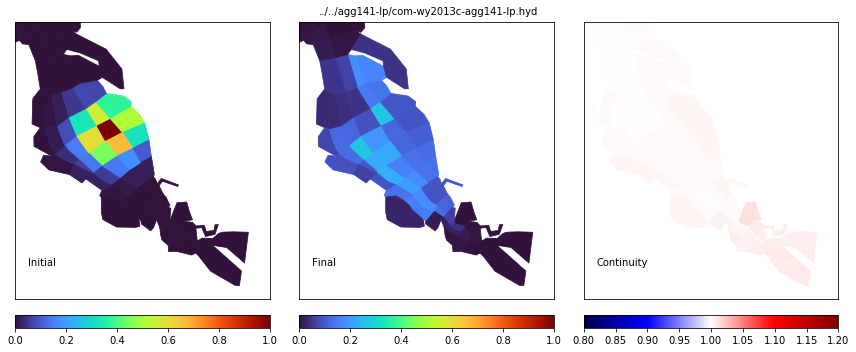

In [12]:
Blobber(hydro=hydro_orig,force=False).complete()
#Blobber(hydro=hydro_agg6k).complete()
#Blobber(hydro=hydro_agg6k_lp).complete()
#Blobber(hydro=hydro_agg141).complete()
Blobber(hydro=hydro_agg141_lp,force=True).complete()
;

Lower South Bay Blob
==

''

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


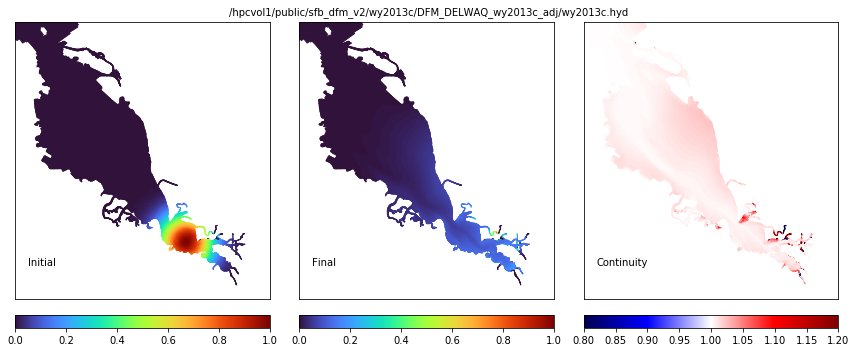

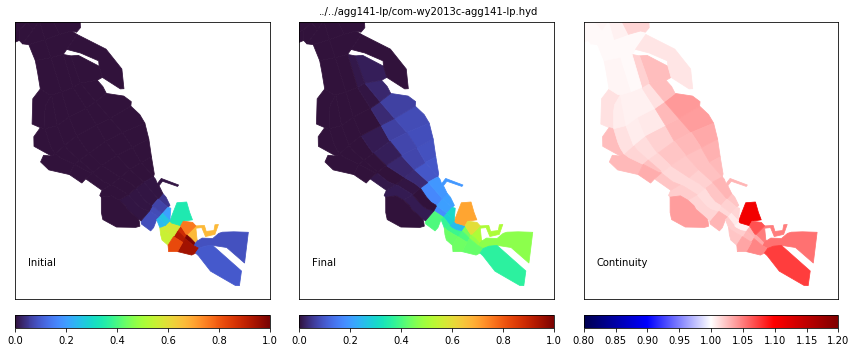

In [8]:
BlobLSB(hydro=hydro_orig).complete()
#BlobLSB(hydro=hydro_agg6k).complete()
#BlobLSB(hydro=hydro_agg6k_lp).complete()
#BlobLSB(hydro=hydro_agg141).complete()
BlobLSB(hydro=hydro_agg141_lp).complete()
;

Time Series of Tracer within a Region
==

These runs initialize a region to a unit concentration, and follow the evolution
of the average tracer concentration in the region as it is flushed out.



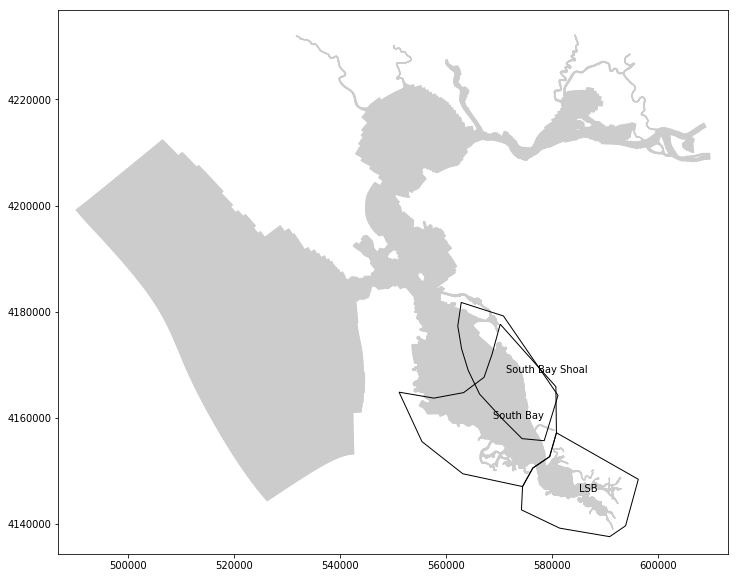

In [7]:
# copied from tally_regions_01.shp
south_bay=wkt.loads("""
Polygon ((570184.11757621716242284 4177639.10577381495386362, 580673.98798651667311788 4165868.02981721935793757, 580779.51211822277400643 4157176.39687086036428809,
                579502.36535809095948935 4152682.20969413500279188, 576316.89153041841927916 4150518.94015444722026587, 574393.47667129873298109 4147040.97573396936058998,
                563137.487071588402614   4149452.58375529991462827, 555436.04330817516893148 4155509.96108419680967927, 551126.1850750622106716  4164827.05031085386872292,
                557692.36349982989486307 4163705.9954578448086977,  563297.63776487542781979 4164746.97496421029791236, 567141.25440376379992813 4167629.68744337651878595,
                568662.68598999048117548 4172033.83150876965373755, 570184.11757621716242284 4177639.10577381495386362))""")

lsb=wkt.loads("""
Polygon ((574393.47667129873298109 4147040.97573396936058998, 576316.89153041841927916 4150518.94015444722026587, 579502.36535809095948935 4152682.20969413500279188, 
                580779.51211822277400643 4157176.39687086036428809, 596208.60523535730317235 4148411.60424893442541361, 593807.15548636857420206 4139647.13588713435456157, 
                590809.89551359775941819 4137600.78393180714920163, 581394.6661063083447516  4139202.93938493076711893, 574187.88490839255973697 4142646.17929060151800513, 
                574393.47667129873298109 4147040.97573396936058998))
""")


southbay_shoal=wkt.loads("""
Polygon ((562839.59208628651686013 4181732.48768383450806141, 570785.53009771392680705 4179192.39274575561285019, 581076.17112890689168125 4164212.34567503165453672, 
          578470.945551389711909   4155680.23190866271033883, 574302.58462736220099032 4156071.01574529008939862, 570785.53009771392680705 4159588.0702749383635819, 
          566291.51597649673931301 4164472.86823278339579701, 564142.20487504510674626 4168966.88235400058329105, 562904.7227257244521752 4173004.98199915187433362, 
          562188.2856919071637094 4177303.60420205537229776, 562839.59208628651686013 4181732.48768383450806141))
""")
#south_bay.union(lsb)

# Show where those regions fall:
fig=plt.figure(figsize=[12,10])
ax=fig.add_subplot(1,1,1)

hydro_orig.grid().plot_cells(color='0.8',ax=ax)
ax.axis('equal')

for poly,name in [ (south_bay,'South Bay'),
                   (lsb,'LSB'),
                   (southbay_shoal,'South Bay Shoal')]:
    plot_wkb.plot_polygon(poly,facecolor='none',ax=ax)
    ax.text(float(poly.centroid.x),
            float(poly.centroid.y),
            name)
    


In [8]:
class ResidenceTime(Blobber):
    """
    Seed with a regional dye release, include time series plots of mass
    within region.
    """
    # plume parameters
    region=None # shapely.geometry or numpy array [N,2] giving polygon for region.
    blob_name="region" # overwrite this below
    cmap=cmap
    def complete(self):
        """
        simulate and plot
        """
        self.run_waq_model()
        self.figure_2panels_and_time()
        return self
    
    def release_conc_2d(self):
        grid=self.hydro.grid()
        
        # Get the region into a shapely geometry
        self.geom=self.region
        if isinstance(self.region,np.ndarray):
            self.geom=geometry.Polygon(self.geom)
            
        c=grid.select_cells_intersecting(self.geom,by_center='centroid')
        c=c.astype(np.float64)
        return c
    
    def setup_tracers(self):
        # boundary condition will default to 0.0
        C_3d=self.release_conc_3d()
        self.wm.substances['dye1']=dwaq.Substance(initial=C_3d)        
        
    def setup_model(self):
        super(ResidenceTime,self).setup_model()
        self.wm.add_monitor_for_geometry(name='region',geom=self.geom)
        #print("There are now %d monitor areas"%(len(self.wm.monitor_areas)))
        
    def figure_2panels_and_time(self):
        ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_map.nc'))
        his_ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_hist.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

        fig=plt.figure(self.fig_num)
        gs=gridspec.GridSpec(1,4)
        
        axs=[fig.add_subplot(gs[:,0]),
             fig.add_subplot(gs[:,1])]
        ax_t=fig.add_subplot(gs[:,2:])
        self.fig=fig
        fig.set_size_inches([12,5],forward=True)

        scal='dye1'
        # initial
        ax=axs[0]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Initial",transform=ax.transAxes,va='top')
        coll_ic=grid_ds.plot_cells(values=ds[scal].isel(time=0,layer=0),ax=ax,cmap=self.cmap,
                                   clim=[0,1])
        # at the end 
        ti=len(ds.time)-1
        ax=axs[1]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Final",transform=ax.transAxes,va='top')
        coll_ec=grid_ds.plot_cells(values=ds[scal].isel(time=-1,layer=0),ax=ax,cmap=self.cmap,
                                   clim=[0,1])

        for coll in [coll_ic,coll_ec]:
            coll.set_lw(0.75)
            coll.set_edgecolor('face')
            
        for ax in axs[:2]:
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)

        ax_t.plot(his_ds.time,his_ds.bal.sel(region='region',field='dye1'))
        
        fig_title=self.hydro.hyd_path
        if self.base_x_dispersion!=0.0:
            fig_title+= " Kx=%g"%self.base_x_dispersion

        fig.text(0.5,0.95,fig_title,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text

        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.
        his_ds.close()

Tracer distributions
--

More direct quantitative comparisons are below, but this series of plots shows the
spatial distribution of the plumes after 5 days. Unlike the time series
later on, this reveals some finer detail and exposes some artifacts not apparent
when the results are summarized in a time series plot.

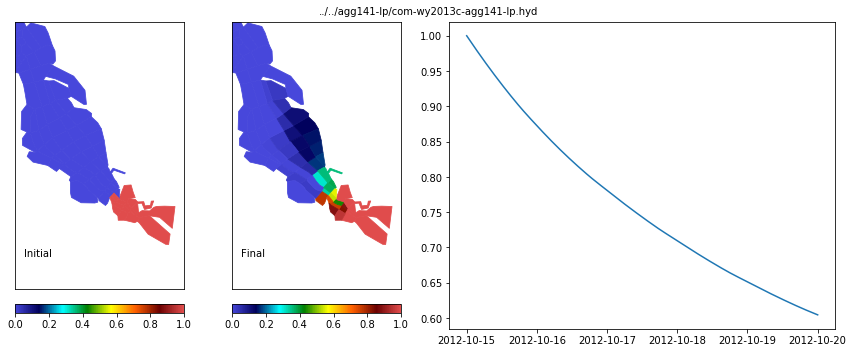

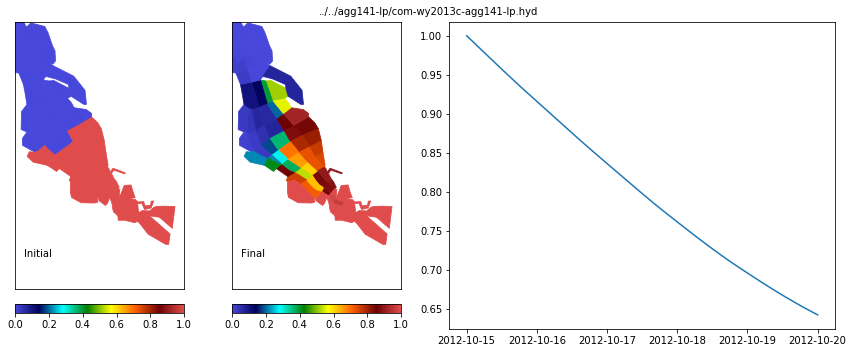

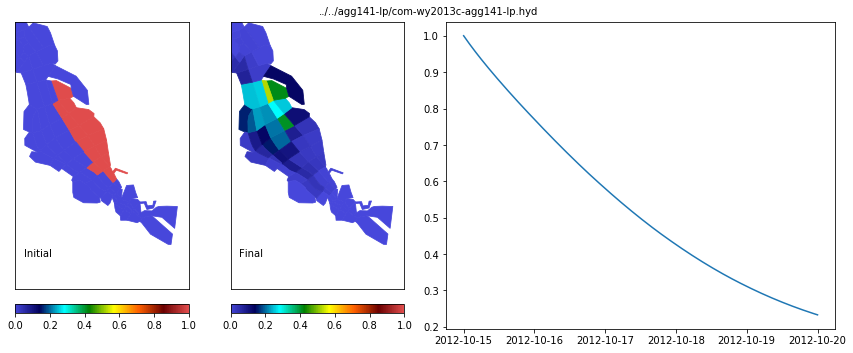

In [9]:
# Example of tracer release
# iterate over different regions, 
# the two base hydro datasets,
# and different global dispersion coefficients

regions=[(lsb,'lsb'),
         (south_bay.union(lsb),'southbay'), # all of South/LSB
         (southbay_shoal,'southbay_shoal')
        ]
# 600 wasn't stable with agg6k_lp.
Kxs=[0]

#hydros=[hydro_agg6k,hydro_agg141,hydro_agg6k_lp,hydro_agg141_lp, hydro_orig]
hydros=[hydro_agg141_lp]

start_periods=[ (np.timedelta64(75,'D'),'Oct')]

for region,blob_name in regions:
    for start_offset,start_name in start_periods:
        results=[]
        styles=[]

        for Kxi,Kx in enumerate(Kxs):
            #color=cmap(float(Kxi)/(len(Kxs)-1.))

            ls=['-','--','-.',':']
            for hydro in hydros:
                if Kx>0 and "orig" in hydro.name:
                    continue # don't bother adding dispersion to original
                log.info("Processing %s"%hydro.name)
                res=ResidenceTime(hydro=hydro,base_x_dispersion=Kx,region=region,blob_name=blob_name,
                                  cmap=scmap.load_gradient('hot_desaturated.cpt'))
                res.run_waq_model()
                results.append(res)
                if 'orig' in hydro.name:
                    styles.append( dict(color='0.5',lw=3) )
                else:
                    styles.append( dict(ls=ls[0]) )
                ls.append(ls.pop(0)) # rotate

        # Plot each one:
        for res in results:
            res.figure_2panels_and_time()



Temporal Variability
--

In order to understand the necessity of time-varying dispersion coefficients,
this section considers two choices of global dispersion coefficient, but for four
different time periods:

 1. dry season, spring
 2. dry season, neap
 3. wet season, spring
 4. wet season, neap

The results suggest that spring-neap variation is important, and seasonal variation is probably
not important.

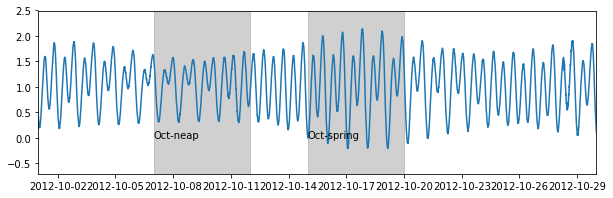

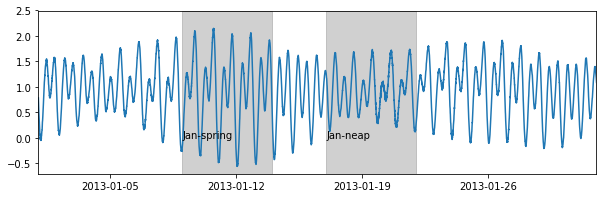

In [10]:
# Choosing periods:
# Grab SF tide data to make the choice
from stompy.io.local import noaa_coops
sf_tides=noaa_coops.coops_dataset_product(station=9414290,start_date=hydro_orig.t_dn[0],end_date=hydro_orig.t_dn[-1],
                                          product='water_level',cache_dir='.')

# these are hand-tuned to fall in reasonable periods based on the tide data
start_periods=[(np.timedelta64(67,'D'),'Oct-neap'),
               (np.timedelta64(75,'D'),'Oct-spring'),
               (np.timedelta64(169,'D'),'Jan-neap'),
               (np.timedelta64(161,'D'),'Jan-spring'),]

for xmin,xmax in [ (np.datetime64("2012-10-01"),np.datetime64("2012-10-30")),  # Dry season
                   (np.datetime64("2013-01-01"),np.datetime64("2013-02-01"))   # Wet season
             ]:
    plt.figure(figsize=[10,3])
    plt.plot(sf_tides.time,sf_tides.water_level.isel(station=0))
    plt.axis(xmin=xmin,xmax=xmax)

    for offset,name in start_periods:
        start=hydro_orig.t_dn[0] + offset/np.timedelta64(1,'D')
        run_duration=5 # days
        plt.axvspan(start,start+run_duration,color='0.4',alpha=0.3) # span doesn't understand dt64
        plt.text(start,0,name,clip_on=True)

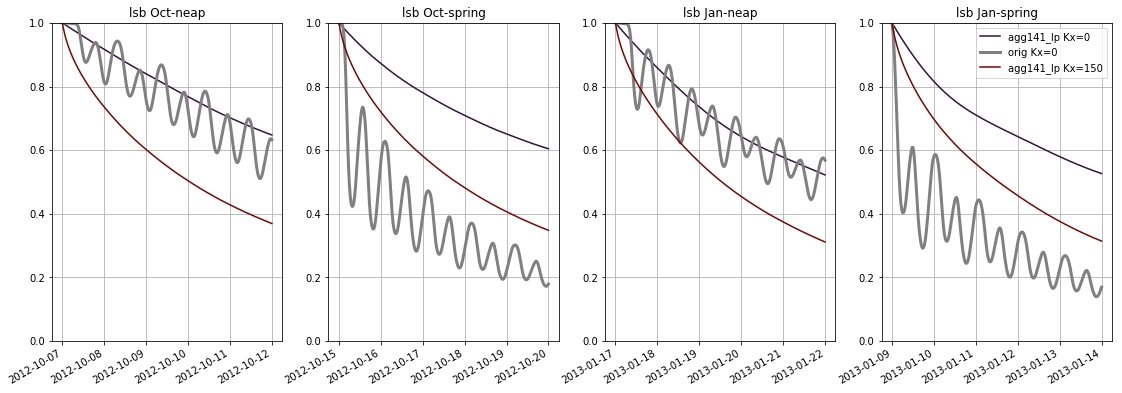

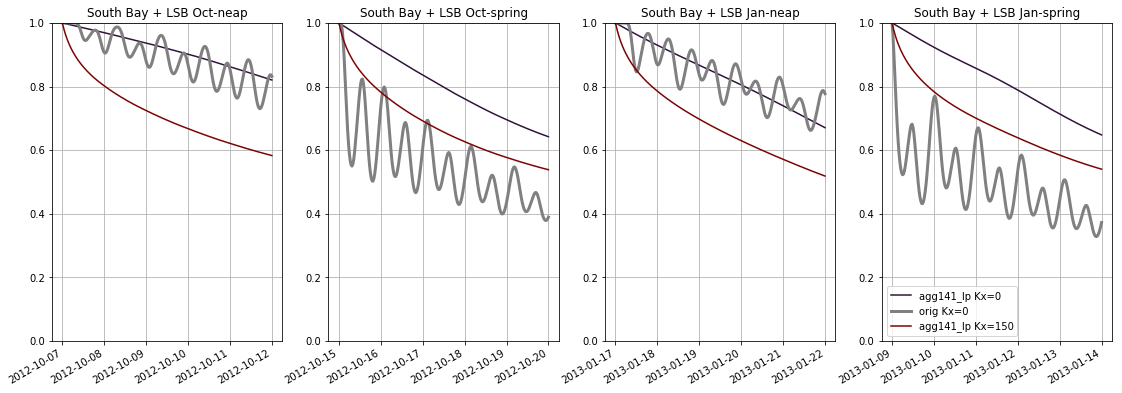

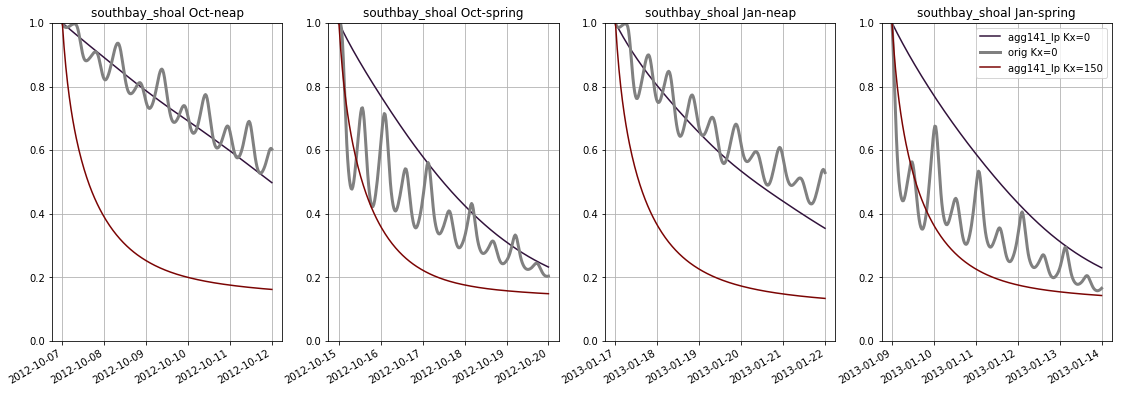

In [12]:
# iterate over different regions, 
# the two base hydro datasets,
# and different global dispersion coefficients

regions=[(lsb,'lsb'),
         (south_bay.union(lsb),'southbay'), # all of South/LSB
         (southbay_shoal,'southbay_shoal')
        ]
# 600 wasn't stable with agg6k_lp.
Kxs=[0, 150]

hydros=[hydro_agg141_lp, hydro_orig]

# start periods set above

for region,blob_name in regions:
    # One figure with an axes per time period
    fig,axs=plt.subplots(1,len(start_periods),figsize=[19,6.5])

    for ax,(start_offset,start_name) in zip(axs,start_periods):
        results=[]
        styles=[]

        for Kxi,Kx in enumerate(Kxs):
            color=cmap(float(Kxi)/(len(Kxs)-1.))

            ls=['-','--','-.',':']
            for hydro in hydros:
                if Kx>0 and "orig" in hydro.name:
                    continue # don't bother adding dispersion to original
                log.info("Processing %s"%hydro.name)
                res=ResidenceTime(hydro=hydro,base_x_dispersion=Kx,region=region,blob_name=blob_name,
                                  start_offset=start_offset)
                #print("Res: base_path: %s  start_offset: %s"%(res.base_path,start_offset))
                res.run_waq_model()
                results.append(res)
                if 'orig' in hydro.name:
                    styles.append( dict(color='0.5',lw=3) )
                else:
                    styles.append( dict(color=color,ls=ls[0]) )
                ls.append(ls.pop(0)) # rotate

        for res,style in zip(results,styles):
            hist_ds=res.wm.hist_ds()
            ax.plot(hist_ds.time,hist_ds.bal.sel(region='region',field='dye1'),
                    label=res.hydro.name+" Kx=%g"%res.base_x_dispersion,**style)
        if ax==axs[-1]:
            ax.legend()
        if blob_name=='southbay':
            title="South Bay + LSB"
        else:
            title=blob_name
        title+= " " + start_name
        ax.set_title(title) 
        ax.axis(ymax=1,ymin=0.)
        ax.grid(1)
    fig.autofmt_xdate()

Effect of Integration Method
--

Based on the page of the manual that Allie pointed out, the main options 
are 15 (what we've been using), 12 (time-step limited but higher order),
or 22 (a mix of those, using 12 when possible).

At the original timestep of 30 minutes, 12 was not stable. 22 was stable and
less diffusive (southbay shoal mixing was maybe 80% the rate of option 15).

At a 10 minute time step, 12 was still not stable. With a 2 minute time step it was 
stable for 20 hours, beyond which the data are nan. In those 20 hours, it appears
to be slightly less diffusive than 22, though the difference is less dramatic 
than between 15 and 22. A time step of 1 minute only affords a few more hours of
stability, with no change in the timeseries.

Going forward, 22 (specifically 22.60 -- the decimal portion enables some other
features), appears to be the best.

In [ ]:
regions=[ (southbay_shoal,'southbay_shoal') ]

Kx=0

hydros=[hydro_orig]

integrators=["15.60","22.60","12.60","12.60","12.60","12.60"]
time_steps=[3000,3000,3000,1000,200,100] 

start_periods_sel=start_periods[:1]


for region,blob_name in regions:
    # One figure with an axes per time period
    fig,axs=plt.subplots(1,len(start_periods_sel),figsize=[19,6.5],squeeze=False)
    axs=axs[0,:]

    for ax,(start_offset,start_name) in zip(axs,start_periods_sel):
        results=[]
        styles=[]

        for integ_i,(integ,time_step) in enumerate(zip(integrators,time_steps)):
            color=cmap(float(integ_i)/(len(integrators)-1.))

            ls=['-','--','-.',':']
            for hydro in hydros:
                log.info("Processing %s"%hydro.name)
                res=ResidenceTime(hydro=hydro,base_x_dispersion=Kx,region=region,blob_name=blob_name,
                                  start_offset=start_offset,integration_option=integ,
                                  time_step=time_step)
                print("Res: base_path: %s  start_offset: %s"%(res.base_path,start_offset))
                res.run_waq_model()
                results.append(res)
                styles.append( dict(color=color,ls=ls[0]) )
                ls.append(ls.pop(0)) # rotate

        for res,style in zip(results,styles):
            hist_ds=res.wm.hist_ds()
            ax.plot(hist_ds.time,hist_ds.bal.sel(region='region',field='dye1'),
                    label=res.hydro.name+" int=%s step=%s"%(res.integration_option,res.time_step),**style)
        if ax==axs[-1]:
            ax.legend()
        if blob_name=='southbay':
            title="South Bay + LSB"
        else:
            title=blob_name
        title+= " " + start_name
        ax.set_title(title) 
        ax.axis(ymax=1,ymin=0.)
        ax.grid(1)
    fig.autofmt_xdate()

Anisotropic diffusion
==

Start with a global anisotropic dispersion tensor.

Following the groundwater literature, $K_{ij}$ scales the flux in the i'th component due to a gradient in the j'th
component.

For isotropic dispersion that's:
```
 K  0
 0  K
```

For axis-aligned anisotropic it would be
```
 Kx  0
 0   Ky
```

The specific case of diffusion oriented at a 45-degree angle between +x and +y:
```
K/2  K/2  
K/2  K/2
```

For an arbitrary gradient the flux vector is:
$$
\left[ {\begin{array}{cc}
 K/2 & K/2 \\
 K/2 & K/2 \\
\end{array} }
\right]
\left[ {\begin{array}{c}
 n_x \\
 n_y \\
 \end{array} }
\right]
= \frac{K}{2} \left[ {\begin{array}{c}
 n_x + n_y \\
 n_x + n_y \\
 \end{array} }
\right]
$$

Which demonstrates that a gradient of $[n_x,n_y]=[-1,1]$ would have no dispersive flux. For a finite volume code, both the gradient and the resulting flux are constrained to the normal vector for each edge. Now allowing an arbitrary dispersion tensor, we get

$$
J=
\left[ {\begin{array}{cc}
n_x & n_y \\
\end{array}} \right]
\left[ {\begin{array}{cc}
 K_{xx} & K_{xy} \\
 K_{xy} & K_{yy} \\
\end{array} }
\right]
\left[ {\begin{array}{c}
 n_x \\
 n_y \\
 \end{array} }
\right]
= K_{xx}n_x^2 + K_{yy}n_y^2 + 2K_{xy}n_xn_y
$$

Rather than specifying the components of the tensor directly, it is often more intuitive to specify the major and minor 
components, and a rotation. This works out to 

$$
K_{ij}=
\left[ {\begin{array}{cc}
K_{maj}\cos^2\theta + K_{min}\sin^2\theta  & (K_{maj}-K_{min})\cos\theta\sin\theta \\
(K_{maj}-K_{min})\cos\theta\sin\theta & K_{maj}\sin^2\theta + K_{min}\cos^2\theta \\
\end{array}}
\right]
$$


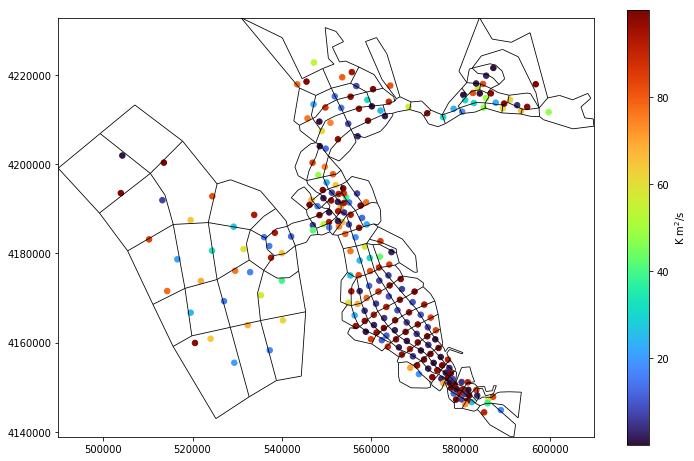

In [25]:
# Configuration for anisotropic dispersion

class ResidenceTimeKxy(ResidenceTime):
    """
    Extra code for specifying anisotropic dispersion. this could be moved
    to a mix-in class, or even part of Blobber. 
    """
    Kxy=(0,0,0) # Kxx, Kyy, Kxy
    def calc_base_path(self):
        base_path=super(ResidenceTimeKxy,self).calc_base_path()
        if self.Kxy!=(0,0,0):
            base_path+="_%g-%g-%g"%(self.Kxy[0],self.Kxy[1],self.Kxy[2])
        return base_path

    def setup_model(self):
        super(ResidenceTimeKxy,self).setup_model()
        Kexch=self.disp_array()
        self.wm.dispersions['anisoK']=dwaq.DispArray(substances=".*",data=Kexch)
    def disp_array(self):
        self.hydro.infer_2d_elements()
        self.hydro.infer_2d_links()
        
        K=np.zeros(self.hydro.n_exch,np.float64)

        # use centroids to get edge normals. 
        g_cc=self.hydro.grid().cells_centroid()
        link_vec=np.zeros((len(self.hydro.links),2),np.float64)
        int_links=np.all(self.hydro.links>=0,axis=1) # interior links

        link_vec[int_links,:] = utils.to_unit( g_cc[ self.hydro.links[int_links,1]] - g_cc[ self.hydro.links[int_links,0]] )
        # project tensor onto edge normal
        link_K=self.Kxy[0]*link_vec[:,0]**2 + self.Kxy[1]*link_vec[:,1]**2 + 2*self.Kxy[2]*link_vec[:,0]*link_vec[:,1]
        K[:self.hydro.n_exch_x]=link_K[self.hydro.exch_to_2d_link['link']]
        return K
    def plot_dispersion(self):
        Kexch=self.disp_array()
        # map that back to links
        link_K=[ Kexch[exchs[0]] for link,exchs in utils.enumerate_groups(self.hydro.exch_to_2d_link['link'])]
        link_K=np.array(link_K)
        g_cc=self.hydro.grid().cells_centroid()
        link_ctr=np.zeros((len(self.hydro.links),2),np.float64)
        int_links=np.all(self.hydro.links>=0,axis=1) # interior links
        link_ctr[int_links,:] = 0.5*(g_cc[ self.hydro.links[int_links,1]] + g_cc[ self.hydro.links[int_links,0]] )
        plt.figure(figsize=(12,8))
        self.hydro.grid().plot_edges(color='k')
        scat=plt.scatter(link_ctr[int_links,0],
                         link_ctr[int_links,1],
                         30,
                         link_K[int_links],cmap=cmap)
        plt.colorbar(scat,label="K m$^2$/s") 

res=ResidenceTimeKxy(hydro=hydro_agg141_lp,Kxy=[50,50,-50])
res.plot_dispersion()

In [26]:
regions=[(lsb,'lsb'),
         (south_bay.union(lsb),'southbay'), # all of South/LSB
         (southbay_shoal,'southbay_shoal')
        ]

def Krot(Kmaj,Kmin,theta_deg):
    """
    Rotated dispersion tensor. 
    Kmaj: dispersion along the major axis
    Kmin: dispersion along minor axis.
    assumes that the inputs are axis-aligned, so the cross-term is 0.
    theta_deg: rotation in degrees CCW, starting from Kmaj=Kxx.
    """
    theta=theta_deg*np.pi/180.
    Kxx=Kmaj*np.cos(theta)**2+Kmin*np.sin(theta)**2
    Kyy=Kmaj*np.sin(theta)**2+Kmin*np.cos(theta)**2
    Kxy=(Kmaj-Kmin)*np.cos(theta)*np.sin(theta)
    return (Kxx,Kyy,Kxy)

# neap period:
# start_offset,start_name=start_periods[0]
# Seems that for this period, zero dispersion is the best.

# spring period:
start_offset,start_name=start_periods[1]

Kxys=[ (0,0,0), # pretty good for neap.
       (150,150,0), # isotropic 150
       Krot(150,0,115), # 150 m2/s, NNw-ish.  pretty good for spring
       Krot(150,0,115+90), # Should be really bad
     ]

Res: base_path: run_orig_lsb  start_offset: 75 days
Res: base_path: run_agg141_lp_lsb  start_offset: 75 days
Res: base_path: run_agg141_lp_lsb_150-150-0  start_offset: 75 days
Res: base_path: run_agg141_lp_lsb_26.7909-123.209--57.4533  start_offset: 75 days
Res: base_path: run_agg141_lp_lsb_123.209-26.7909-57.4533  start_offset: 75 days
Res: base_path: run_orig_southbay  start_offset: 75 days
Res: base_path: run_agg141_lp_southbay  start_offset: 75 days
Res: base_path: run_agg141_lp_southbay_150-150-0  start_offset: 75 days
Res: base_path: run_agg141_lp_southbay_26.7909-123.209--57.4533  start_offset: 75 days
Res: base_path: run_agg141_lp_southbay_123.209-26.7909-57.4533  start_offset: 75 days
Res: base_path: run_orig_southbay_shoal  start_offset: 75 days
Res: base_path: run_agg141_lp_southbay_shoal  start_offset: 75 days
Res: base_path: run_agg141_lp_southbay_shoal_150-150-0  start_offset: 75 days
Res: base_path: run_agg141_lp_southbay_shoal_26.7909-123.209--57.4533  start_offset: 75 

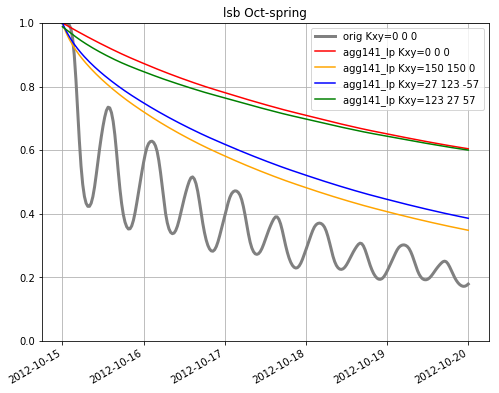

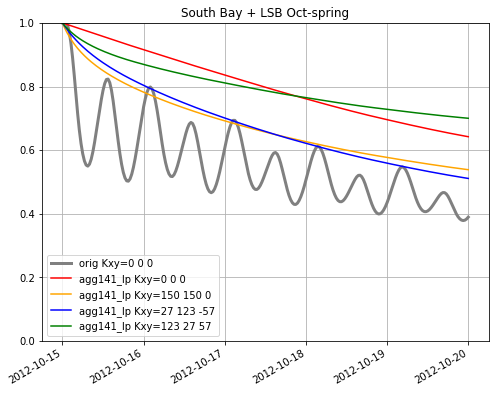

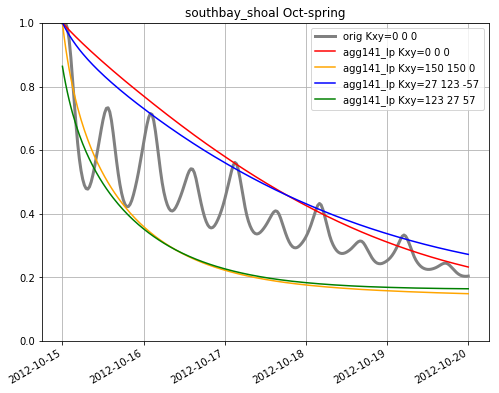

In [27]:
hydros=[hydro_orig,hydro_agg141_lp]

colors=['r','orange','blue','green','purple']

for region,blob_name in regions:
    fig,ax=plt.subplots(1,1,figsize=[8,6.5])
    
    results=[]
    styles=[]

    for Kxyi,Kxy in enumerate(Kxys):
        color=colors[Kxyi] # ugly. cmap(float(Kxyi)/(len(Kxys)-1.))

        ls=['-','--','-.',':']
        for hydro in hydros:
            if Kxy[0]>0 and Kxy[1]>0 and "orig" in hydro.name:
                continue # don't bother adding dispersion to original
            log.info("Processing %s"%hydro.name)
            res=ResidenceTimeKxy(hydro=hydro,Kxy=Kxy,region=region,blob_name=blob_name,
                                 start_offset=start_offset)
            print("Res: base_path: %s  start_offset: %s"%(res.base_path,start_offset))
            res.run_waq_model()
            results.append(res)
            if 'orig' in hydro.name:
                styles.append( dict(color='0.5',lw=3) )
            else:
                styles.append( dict(color=color, ls=ls[0]) )
                ls.append(ls.pop(0)) # rotate

    for res,style in zip(results,styles):
        hist_ds=res.wm.hist_ds()
        hist_ds.load()
        ax.plot(hist_ds.time,hist_ds.bal.sel(region='region',field='dye1'),
                label=res.hydro.name+" Kxy=%.0f %.0f %.0f"%res.Kxy,**style)
        hist_ds.close()
    ax.legend()
    if blob_name=='southbay':
        title="South Bay + LSB"
    else:
        title=blob_name
    title+= " " + start_name
    ax.set_title(title) 
    ax.axis(ymax=1,ymin=0.)
    ax.grid(1)
    fig.autofmt_xdate()

Scaling Dispersion from Tidal--Nontidal Difference
--

As a halfway point between (a) a direct calculation of what the dispersion 
coefficient "should" be, and (b) prescribing anisotropic dispersion coefficients
through blind optimization, there is a middle ground of correlating
dispersion with features of the hydrodynamics. This section looks at
the feasibility of using the difference between the tidal and non-tidal
advective fluxes as a predictor of dispersion coefficient.

The scaling here is important. Fluxes are m$^3$/s, and dispersion coefficients
are m$^2$/s.

As a thought experiment, consider a case where each tidal cycle
leads to a net exchange of 10% of the volume between two control
volumes of equal size. In a subtidal representation of this system,
that flux is the product of the difference in concentrations, the
area of their common face, and divided by the length between them.

If we assume that the dispersive flux should scale with the rms
tidal flux, then to get the corresponding dispersion coefficient we
scale rms flux by length/area.

Overall, the approach is promising, and with tuning a single
parameter it comes close to performing as well as the Kxy approach
which required 2-3 parameters (and even then, the parameters are
specific to the 3 test regions).

In [ ]:
hydro_tidal=hydro_agg141
hydro_subtidal=hydro_agg141_lp
hydros=[hydro_tidal,hydro_subtidal]


class ResidenceTimeKauto(ResidenceTimeKxy): 
    # choose some period over which to look at the stats
    ti_start=2000
    ti_stop =2200
    hydro_tidal=None # set this to a tidal version of self.hydro
    K_scale=0.02 # non-dimensional scaling from Qexch*L/A => dispersion coefficient.
    
    def calc_base_path(self):
        base_path=super(ResidenceTimeKauto,self).calc_base_path()
        base_path+="_Kauto"
        return base_path

    def disp_array(self):
        self.hydro.infer_2d_elements()
        self.hydro.infer_2d_links()
        
        K=np.zeros(self.hydro.n_exch,np.float64)

        Qaccum=np.zeros(self.hydro.n_2d_links,np.float64)
        Aaccum=np.zeros(self.hydro.n_2d_links,np.float64)
        accum_count=0

        for ti in range(self.ti_start,self.ti_stop):
            t_sec=hydro.t_secs[ti]
            flows=[ hydro.flows(t_sec) for hydro in [self.hydro_tidal,self.hydro]]
            flow_hp=flows[0] - flows[1]
            # depth-integrate
            flow_hor=flow_hp[:hydro_tidal.n_exch_x]
            link_flows=np.bincount( self.hydro.exch_to_2d_link['link'],
                                    self.hydro.exch_to_2d_link['sgn']*flow_hor)
            
            Qaccum+=link_flows**2
            Aaccum+=np.bincount( self.hydro.exch_to_2d_link['link'],self.hydro.areas(t_sec)[:self.hydro.n_exch_x])
            accum_count+=1
        rms_flows=np.sqrt(Qaccum/accum_count)
        mean_A=Aaccum/accum_count
        
        Lexch=self.hydro.exchange_lengths.sum(axis=1)[:self.hydro.n_exch_x]
        L=[Lexch[exchs[0]] for l,exchs in utils.enumerate_groups(self.hydro.exch_to_2d_link['link'])]
        
        # This is just a placeholder. A proper scaling needs to account for 
        # cell size. rms_flows has units of m3/s. probably that should be normalized
        # by dividing by average flux area, and possibly multiplying by the distance
        # between cell centers. that doesn't seem quite right.
        link_K=self.K_scale*rms_flows*L/mean_A
        K[:self.hydro.n_exch_x]=link_K[self.hydro.exch_to_2d_link['link']]
        
        return K

res=ResidenceTimeKauto(hydro=hydro_agg141_lp,hydro_tidal=hydro_agg141)
res.plot_dispersion()
plt.gca().collections[1].set_norm(colors.LogNorm(vmin=1))

In [ ]:
duration=np.timedelta64(5,'D')

for region,blob_name in regions:
    fig,ax=plt.subplots(1,1,figsize=[8,6.5])
    
    results=[]
    styles=[]

    colors=['k','b','g','orange','r']
    ls=['-','--','-.',':']
    for res in [
        ResidenceTimeKxy(hydro=hydro_orig,region=region,blob_name=blob_name,
                         start_offset=start_offset,duration=duration),
        ResidenceTimeKauto(hydro=hydro_agg141_lp,region=region,blob_name=blob_name,
                           hydro_tidal=hydro_agg141,force=True,K_scale=0.2,
                           start_offset=start_offset,duration=duration),
        ResidenceTimeKxy(hydro=hydro_agg141_lp,region=region,blob_name=blob_name,
                         Kxy=Krot(150,0,115),start_offset=start_offset,duration=duration),
        ResidenceTimeKxy(hydro=hydro_agg141_lp,region=region,blob_name=blob_name,
                         Kxy=(0,0,0),start_offset=start_offset,duration=duration),
        ResidenceTimeKxy(hydro=hydro_agg141_lp,region=region,blob_name=blob_name,
                         Kxy=Krot(150,150,0),start_offset=start_offset,duration=duration),
        
    ]:        
        print("Res: base_path: %s"%(res.base_path))
        res.run_waq_model()
        results.append(res)
        color=colors[0]
        if 'orig' in hydro.name:
            styles.append( dict(color='0.5',lw=3) )
        else:
            styles.append( dict(color=color,ls=ls[0]) )
        ls.append(ls.pop(0)) # rotate
        colors.append(colors.pop(0))

    for res,style in zip(results,styles):
        hist_ds=res.wm.hist_ds()
        hist_ds.load()
        ax.plot(hist_ds.time,hist_ds.bal.sel(region='region',field='dye1'),
                label=res.base_path,**style)
        hist_ds.close()
    ax.legend()
    if blob_name=='southbay':
        title="South Bay + LSB"
    else:
        title=blob_name
    title+= " " + start_name
    ax.set_title(title) 
    ax.axis(ymax=1,ymin=0.)
    ax.grid(1)
    fig.autofmt_xdate()

Continuous Release
==

Unlike the tests above, here the tracer source is a point with a continuous
mass-per-time discharge. So far it runs, but no analysis yet. One avenue
for analysis is to run release for 15-25 days, and compare the spatial
distribution of the resulting plumes. For qualitative comparison that's
straightforward. To get quantitative, it may be most appropriate to 
average the output from the original grid onto the aggregated grid, then
evaluate how close the two sets of concentrations are.

In [ ]:
class OutfallPlume(Blobber):
    """
    Extend to adding continous sources
    """
    # set length of the run -- for continuous release go for longer duration
    duration=np.timedelta64(15,'D')
    blob_name='sbOutfall' 
    
    def complete(self):
        """
        simulate and plot
        """
        self.run_waq_model()
        self.figure_3panels()
        return self # makes for more compact iteration loops later
        
    def setup_tracers(self):
        # boundary condition will default to 0.0
        self.wm.substances['dye1']=dwaq.Substance(initial=0.0)
        elt=self.hydro.grid().select_cells_nearest(self.X0)
        discharge=self.wm.add_discharge(element=elt,k=0)
        self.wm.add_load([discharge],['dye1'],100.0)
        
    def figure_3panels(self):
        ds=xr.open_dataset(os.path.join(self.wm.base_path,'dwaq_map.nc'))
        grid_ds=unstructured_grid.UnstructuredGrid.from_ugrid(ds)

        fig,axs=plt.subplots(1,2,num=self.fig_num)
        self.fig=fig
        fig.set_size_inches([12,5],forward=True)

        scal='dye1'
        # initial
        ax=axs[0]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Initial",transform=ax.transAxes,va='top')
        coll_ic=grid_ds.plot_cells(values=ds[scal].isel(time=0,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])
        # at the end 
        ti=len(ds.time)-1
        ax=axs[1]
        ax.text(self.txt_loc[0],self.txt_loc[1],"Final",transform=ax.transAxes,va='top')
        coll_ec=grid_ds.plot_cells(values=ds[scal].isel(time=-1,layer=0),ax=ax,cmap=cmap,
                                   clim=[0,1])

        for coll in [coll_ic,coll_ec]:
            coll.set_lw(0.75)
            coll.set_edgecolor('face')
            
        for ax in axs:
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)
            ax.axis('equal')
            ax.axis(self.zoom)
            plt.colorbar(ax.collections[0],orientation='horizontal',ax=ax,fraction=0.08,pad=0.05)

        fig_title=self.hydro.hyd_path
        if self.base_x_dispersion!=0.0:
            fig_title+= " Kx=%g"%self.base_x_dispersion
            
        fig.text(0.5,0.95,fig_title,ha='center')
        fig.tight_layout()
        fig.subplots_adjust(top=0.93) # make some space for fig text

        ds.close() # keeping this open can interfere with deleting or overwriting the netcdf file.
    

for hydro in [hydro_agg141_lp,
              hydro_orig # Takes a while.
             ]:
    OutfallPlume(hydro=hydro).complete()

Results so far
==

Filtering is effective at decreasing dispersion to levels below the high resolution run.

Global dispersion coefficients on the order of 200 m$^2$/s match the non-tidal aggregated runs to the tidal resolved model.

The ideal dispersion coefficient differs between the aggregation geometries, and between the target region, and between spring-neap.

There is less variation in dispersion coefficient at seasonal time scales.

Of the 3 choices for advection scheme, the one that has been used in the past (15) is the most dispersive. Method 22
was stable and performed better than 15, for a ballpark 20% reduction in numerical diffusion. 
A high-order method (12) required much shorter time steps, and was still only temporarily stable at 1 minute time
steps. It showed a small improvement over 22, before crashing.

Anisotropic (directional) dispersion works and is effective at differentiating between longitudinal and lateral dispersion.
So far the specified anisotropic dispersion has only been implemented at a global level, so while it looks promising
when applied to the 3 South Bay test regions, it is doing so at the expense of terrible performance in places like
San Pablo Bay or Suisun Bay.  Perhaps the most promising solution is correlating tidal fluxes to subtidal dispersion.
This does nearly as well as global anisotropic in the tests so far, but with better prospects for incorporating
time and space variability. 

The downside of any of anisotropic approaches is that it increases the amount of code that has to be
run (and maintained) for each DWAQ configuration. For the Kauto approach (scale tidal flux to K_subtidal),
it also needs a tidal run which is in all other ways identical to the non-tidal run. That's not a big
challenge, but increases the fragility of the overall setup by introducing more dependencies.

Continuous release simulations are also working now, though I haven't yet tried using them to evaluate different
configurations.

Likewise, I'm still using the same regions as before, though with some input on other important regions to test
they could be added to the mix.
